In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from simulator import Simulation
from tqdm.auto import tqdm
import itertools
import matplotlib as mpl

warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
def plot_distribution(project_df):    
    fig, ax = plt.subplots(figsize=(8,5))
    project_df['token_amount'].plot(kind='bar', width=1, ax=ax)
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel("Tokens")
    # fig.show()
    
    
def plot_alignment(project_df):    
    fig, ax = plt.subplots(figsize=(8,5))
    project_df.plot(kind='scatter', x='rating', y='token_amount', ax=ax)
    ax.set_ylabel("Tokens")
    ax.set_xlabel("Impact")
    ax.set_xticks([])    
    # fig.show()

def plot_all(project_df, save_fp=None):
    fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)
    project_df['token_amount'].plot(kind='bar', width=1, ax=ax[0])
    project_df.plot(kind='scatter', x='rating', y='token_amount', ax=ax[1])
    ax[0].set_xticks([])
    ax[0].set_xlabel("")
    ax[0].set_ylabel("Tokens Allocated")
    ax[1].set_ylabel("")
    ax[1].set_xlabel("Impact")
    ax[1].set_xticks([])
    plt.tight_layout()
    if save_fp:
        plt.savefig(save_fp)
    
    
def analyze_simulation(results, generate_plots=False):
    summary = pd.Series(results).iloc[:-1].apply(lambda x: int(x) if isinstance(x, float) else x)
    data = results['data']
    project_df = pd.DataFrame(data).sort_values(by='token_amount', ascending=False)
    if generate_plots:
        plot_all(project_df)
    return summary

### Normalize to the voting that we will be doing (270k FIL)

In [4]:
## Num Projects > Quorum when sweeping Quorum
quorum_vec = list(np.arange(1, 10+1))
score_fn = ['sum']  # note quorum doesnt depend on score fn
num_applicants = 50
funding_amt = 270000
min_funding_amt_pct = 0.01
# max_funding_amt_pct_vec = [0.15, 0.2]
# min_funding_to_fund_pct_vec = [0.05, 0.1, 0.15]
max_funding_amt_pct_vec = [0.15]
min_funding_to_fund_pct_vec = [0.05]

sim_configs = list(itertools.product(quorum_vec, score_fn, max_funding_amt_pct_vec, min_funding_to_fund_pct_vec))

results_list = []
for sim_config in tqdm(sim_configs):
    q, score_fn, max_funding_amt_pct, min_funding_to_fund_pct  = sim_config
    simulation = Simulation()

    # print('#'*10)
    # print(q)
    
    min_funding_amt_badgeholder = 1 # int(min_funding_amt_pct * funding_amt)
    max_funding_amt_badgeholder = int(max_funding_amt_pct * funding_amt)
    min_score_amt = int(min_funding_to_fund_pct * funding_amt)

    simulation.initialize_round(
        max_funding=270000,
        min_project_vote=min_funding_amt_badgeholder,
        max_project_vote=max_funding_amt_badgeholder,
    )
    simulation.randomize_voters(
        num_voters=50, 
        willingness_to_spend=1.0, 
        laziness_factor=0.1, 
        expertise_factor=0.9
    )
    simulation.randomize_projects(
        num_projects=num_applicants
    )

    results = simulation.simulate_voting_and_scoring(
        n=1,
        scoring_method=score_fn,
        quorum=q,
        min_amount=min_score_amt,
        normalize=True,
        count_zero_votes_towards_quorum=False
    )
    summary = analyze_simulation(results, generate_plots=False)
    results_list.append({
        'quorum': q,
        'score_fn': score_fn,
        'min_funding_amt_pct': min_funding_amt_pct,
        'max_funding_amt_pct': max_funding_amt_pct,
        'min_funding_to_fund_pct': min_funding_to_fund_pct,
        'num_projects_above_quorum_mean': summary.num_projects_above_quorum_mean,
        'num_projects_above_quorum_std': summary.num_projects_above_quorum_std
    })
    # project_pass_vec_mean.append(summary.num_projects_above_quorum_mean)
    # project_pass_vec_std.append(summary.num_projects_above_quorum_std)


  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
df = pd.DataFrame(results_list)

In [6]:
df

,quorum,score_fn,min_funding_amt_pct,max_funding_amt_pct,min_funding_to_fund_pct,num_projects_above_quorum_mean,num_projects_above_quorum_std
0,1,sum,0.01,0.15,0.05,47,0
1,2,sum,0.01,0.15,0.05,47,0
2,3,sum,0.01,0.15,0.05,49,0
3,4,sum,0.01,0.15,0.05,47,0
4,5,sum,0.01,0.15,0.05,44,0
5,6,sum,0.01,0.15,0.05,45,0
6,7,sum,0.01,0.15,0.05,44,0
7,8,sum,0.01,0.15,0.05,42,0
8,9,sum,0.01,0.15,0.05,42,0
9,10,sum,0.01,0.15,0.05,43,0


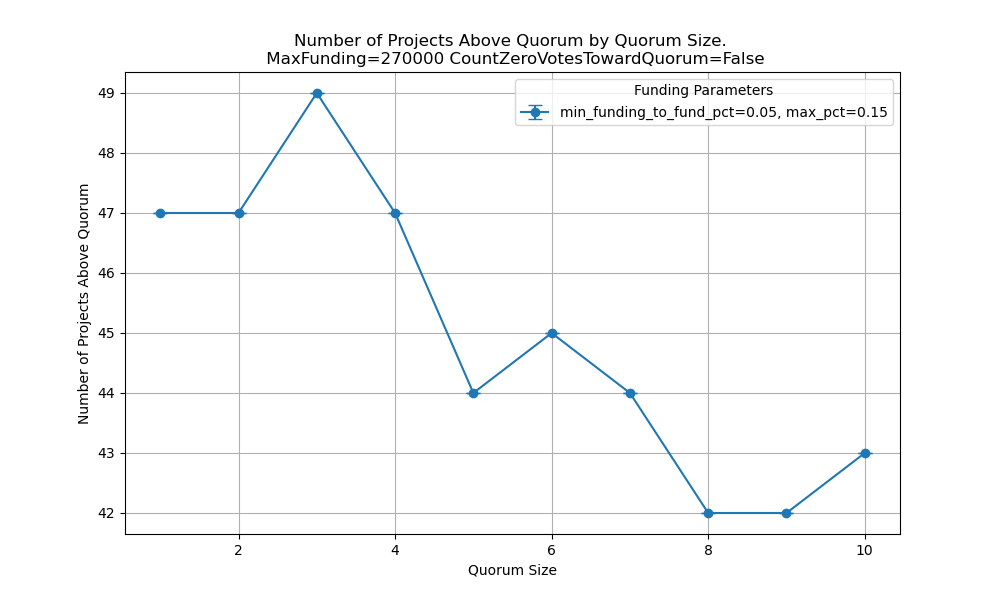

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over unique values of min_funding_amt_pct and max_funding_amt_pct
for min_funding in df['min_funding_to_fund_pct'].unique():
    for max_funding in df['max_funding_amt_pct'].unique():
        # Filter data for each min and max funding percentage
        filtered_data = df[(df['min_funding_to_fund_pct'] == min_funding) & (df['max_funding_amt_pct'] == max_funding)]
        
        # Plot mean with standard deviation error bars
        ax.errorbar(
            filtered_data['quorum'],
            filtered_data['num_projects_above_quorum_mean'],
            yerr=filtered_data['num_projects_above_quorum_std'],
            label=f'min_funding_to_fund_pct={min_funding}, max_pct={max_funding}',
            capsize=5,
            fmt='o-'
        )

# Labeling
ax.set_title('Number of Projects Above Quorum by Quorum Size. \n MaxFunding=%d CountZeroVotesTowardQuorum=False' % funding_amt)
ax.set_xlabel('Quorum Size')
ax.set_ylabel('Number of Projects Above Quorum')
ax.legend(title='Funding Parameters')
plt.grid(True)
plt.show()

scoring_method                      sum
vote_quorum                          10
min_amount                        13500
normalize                          True
num_projects_above_quorum_mean       43
num_projects_above_quorum_std         0
avg_payout                         6279
median_payout                      6488
max_payout                        11530
dtype: object

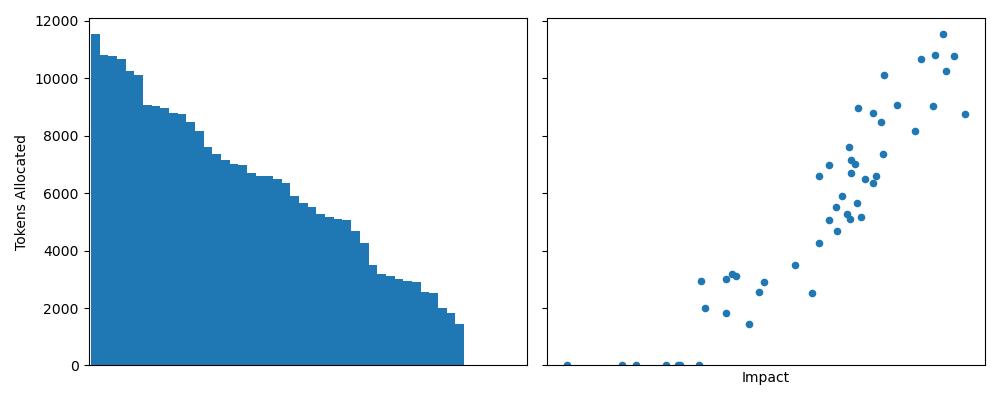

In [8]:
analyze_simulation(results, generate_plots=True)